In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.ml import feature
from pyspark.ml import regression
from pyspark.sql import functions as fn
from pyspark.sql import Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Servo data analysis

```console
1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by Karl Ulrich at MIT in 1986.  I didn't 
   record his description at the time, but here's his subsequent (1992) 
   recollection:
 
     "I seem to remember that the data was from a simulation of a servo
     system involving a servo amplifier, a motor, a lead screw/nut, and a
     sliding carriage of some sort.  It may have been on of the
     translational axes of a robot on the 9th floor of the AI lab.  In any
     case, the output value is almost certainly a rise time, or the time
     required for the system to respond to a step change in a position set
     point."
 
   (Quinlan, ML'93)

   "This is an interesting collection of data provided by Karl 
    Ulrich.  It covers an extremely non-linear phenomenon - predicting the 
    rise time of a servomechanism in terms of two (continuous) gain settings
    and two (discrete) choices of mechanical linkages."

5. Number of Instances: 167

6. Number of Attributes: 4 + numeric class attribute

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10

8. Missing Attribute Values: None
```

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/servo/servo.data"

In [3]:
servo_df = spark.createDataFrame(pd.read_csv(data_url, 
            sep=',', 
            header=None,
            names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))

In [4]:
servo_df.printSchema()

root
 |-- motor: string (nullable = true)
 |-- screw: string (nullable = true)
 |-- pgain: long (nullable = true)
 |-- vgain: long (nullable = true)
 |-- rise_time: double (nullable = true)



# Explore the data

## Use `limit` to plot a sample of the data

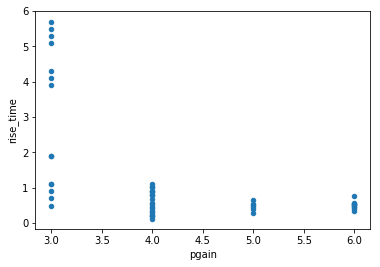

In [7]:
servo_df.limit(50).toPandas().plot(x='pgain', y='rise_time', kind='scatter')

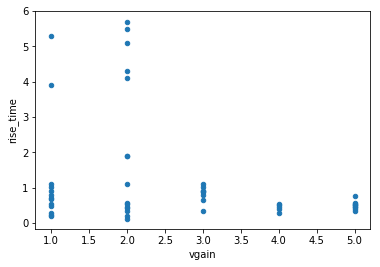

In [8]:
servo_df.limit(50).toPandas().plot(x='vgain', y='rise_time', kind='scatter')

## Perform correlations

In [34]:
# correlations
servo_df.select(fn.corr('pgain', 'rise_time'),fn.corr('vgain', 'rise_time'),fn.corr('pgain', 'vgain')).show()

+----------------------+----------------------+------------------+
|corr(pgain, rise_time)|corr(vgain, rise_time)|corr(pgain, vgain)|
+----------------------+----------------------+------------------+
|   -0.5981287119612234|  -0.36438266626914595|0.8122683058183875|
+----------------------+----------------------+------------------+



## Compute  mean rise_time for different motors and screws

In [51]:
# your code here
servo_df.groupby('motor', 'screw').mean('rise_time').show()

+-----+-----+------------------+
|motor|screw|    avg(rise_time)|
+-----+-----+------------------+
|    E|    E|0.6187516666666667|
|    D|    A|1.1580320357142857|
|    E|    B|1.0026771985714287|
|    B|    C|1.5830305242857141|
|    D|    C|0.9145837666666666|
|    D|    E|0.7000006999999999|
|    A|    A|2.0171983987499997|
|    A|    C|1.6491035671428573|
|    D|    D|0.8520823599999999|
|    C|    B| 1.615173607142857|
|    A|    E|1.6098147800000002|
|    E|    C|0.6580362642857143|
|    C|    C|1.2473184685714285|
|    C|    A|1.3489604899999998|
|    E|    D|0.6979180566666666|
|    C|    D|0.8258923142857143|
|    A|    D|1.6616027514285712|
|    D|    B|0.7687501842857143|
|    E|    A|2.6080661842857147|
|    B|    B|        1.74196167|
+-----+-----+------------------+
only showing top 20 rows



# Feature engineering

## Create a dataframe with columns `motor` and `screw` as dummy variables

In [67]:
# code here
dummy_Df = servo_df.select('motor',
               (fn.col('motor')=='A').cast('float').alias('motor_A'),
               (fn.col('motor')=='C').cast('float').alias('motor_C'),
               (fn.col('motor')=='D').cast('float').alias('motor_D'),
               (fn.col('motor')=='E').cast('float').alias('motor_E'),
               'screw',
               (fn.col('screw')=='B').cast('float').alias('screw_B'),
               (fn.col('screw')=='C').cast('float').alias('screw_C'),
               (fn.col('screw')=='D').cast('float').alias('screw_D'),
               (fn.col('screw')=='E').cast('float').alias('screw_E'),
               'pgain',
               'vgain',
               'rise_time'            
               )
dummy_Df.show(2)

+-----+-------+-------+-------+-------+-----+-------+-------+-------+-------+-----+-----+----------+
|motor|motor_A|motor_C|motor_D|motor_E|screw|screw_B|screw_C|screw_D|screw_E|pgain|vgain| rise_time|
+-----+-------+-------+-------+-------+-----+-------+-------+-------+-------+-----+-----+----------+
|    E|    0.0|    0.0|    0.0|    1.0|    E|    0.0|    0.0|    0.0|    1.0|    5|    4|0.28125095|
|    B|    0.0|    0.0|    0.0|    0.0|    D|    0.0|    0.0|    1.0|    0.0|    6|    5| 0.5062525|
+-----+-------+-------+-------+-------+-----+-------+-------+-------+-------+-----+-----+----------+
only showing top 2 rows



## Standardize vgain and pgain

In [73]:
# your code here
dummy_Df.select(dummy_Df.columns + [
    ((fn.col('vgain') - fn.avg('vgain'))/fn.stddev('vgain')).alias('z_vgain'),
    ((fn.col('pgain') - fn.avg('pgain'))/fn.stddev('pgain')).alias('z_pgain'),
])

AnalysisException: "grouping expressions sequence is empty, and '`motor`' is not an aggregate function. Wrap '(((CAST(`vgain` AS DOUBLE) - avg(`vgain`)) / stddev_samp(CAST(`vgain` AS DOUBLE))) AS `z_vgain`, ((CAST(`pgain` AS DOUBLE) - avg(`pgain`)) / stddev_samp(CAST(`pgain` AS DOUBLE))) AS `z_pgain`)' in windowing function(s) or wrap '`motor`' in first() (or first_value) if you don't care which value you get.;;\nAggregate [motor#0, motor_A#1247, motor_C#1248, motor_D#1249, motor_E#1250, screw#1, screw_B#1251, screw_C#1252, screw_D#1253, screw_E#1254, pgain#2L, vgain#3L, rise_time#4, ((cast(vgain#3L as double) - avg(vgain#3L)) / stddev_samp(cast(vgain#3L as double))) AS z_vgain#1529, ((cast(pgain#2L as double) - avg(pgain#2L)) / stddev_samp(cast(pgain#2L as double))) AS z_pgain#1540]\n+- AnalysisBarrier\n      +- Project [motor#0, cast((motor#0 = A) as float) AS motor_A#1247, cast((motor#0 = C) as float) AS motor_C#1248, cast((motor#0 = D) as float) AS motor_D#1249, cast((motor#0 = E) as float) AS motor_E#1250, screw#1, cast((screw#1 = B) as float) AS screw_B#1251, cast((screw#1 = C) as float) AS screw_C#1252, cast((screw#1 = D) as float) AS screw_D#1253, cast((screw#1 = E) as float) AS screw_E#1254, pgain#2L, vgain#3L, rise_time#4]\n         +- Project [CASE WHEN (motor#0 = E) THEN 1 ELSE 0 END AS E#510, CASE WHEN (motor#0 = B) THEN 1 ELSE 0 END AS B#511, CASE WHEN (motor#0 = D) THEN 1 ELSE 0 END AS D#512, CASE WHEN (motor#0 = C) THEN 1 ELSE 0 END AS C#513, CASE WHEN (motor#0 = A) THEN 1 ELSE 0 END AS A#514, E#493, B#494, D#495, C#496, A#497, motor#0, screw#1, pgain#2L, vgain#3L, rise_time#4]\n            +- Project [CASE WHEN (motor#0 = E) THEN 1 ELSE 0 END AS E#493, CASE WHEN (motor#0 = B) THEN 1 ELSE 0 END AS B#494, CASE WHEN (motor#0 = D) THEN 1 ELSE 0 END AS D#495, CASE WHEN (motor#0 = C) THEN 1 ELSE 0 END AS C#496, CASE WHEN (motor#0 = A) THEN 1 ELSE 0 END AS A#497, motor#0, screw#1, pgain#2L, vgain#3L, rise_time#4]\n               +- LogicalRDD [motor#0, screw#1, pgain#2L, vgain#3L, rise_time#4], false\n"

# Split data into three parts

In [14]:
# your code here

# Propose three regression models

## Fit model with only `pgain`

In [23]:
# code

## Fit model with only `vgain`

In [21]:
# code

## Fit model with only motor, screw, pgain, and vgain

In [24]:
# code

# Compare models

## Estimate RMSE on validation data for the three models

In [26]:
## Pick the best one

In [27]:
# best_model = ...

# Estimate generalization performance (RMSE on testing)

In [28]:
##

# Do inference with best model

In [29]:
# interpret coefficients